In [22]:
import scipy.io
import numpy as np
import pandas as pd
import csv

import matplotlib.pyplot as plt
import matplotlib

import warnings
from datascience import Table
import random
from scipy.signal import savgol_filter
import statsmodels.api as sm
from datascience.predicates import are


In [3]:
google_df = pd.read_csv("master_df_interpolated_data.csv")
nytimes_df = pd.read_csv("../raw_data/nytimes_data/us-counties.csv")

In [4]:
nytimes_df['county'] = nytimes_df['county'].astype(str) + ' County'
google_df['county_st'] = google_df['county'].astype(str) + ', ' + google_df['state'].astype(str)
nytimes_df['county_st'] = nytimes_df['county'].astype(str) + ', ' + nytimes_df['state'].astype(str)

In [6]:
google = Table.from_df(google_df)
nytimes = Table.from_df(nytimes_df)

google

nytimes

In [9]:
g_counties = np.unique(google.column("county_st"))
n_counties = np.unique(nytimes.column("county_st"))

In [15]:
def get_growthRate(county):
    temp = nytimes.where("county_st", county)
    X = np.arange(len(temp.get(0)))
    X = sm.add_constant(X)
    Y = temp.column("cases")
    Y = np.log(np.add(Y, 1))

    mod = sm.OLS(Y, X)
    res = mod.fit()
    return 10**res.params[1]

In [229]:
def get_parameters(county):
    temp = nytimes.where("county_st", county)
    X = np.arange(len(temp.get(0)))
    X = sm.add_constant(X)
    Y = temp.column("cases")
    Y = np.log(np.add(Y, 1))

    mod = sm.OLS(Y, X)
    res = mod.fit()
    return (10**res.params[0]);

In [235]:
parameters = []
for county in n_counties:
    parameters.append(get_parameters(county))

In [236]:
growth_rate = []
for county in n_counties:
    growth_rate.append(get_growthRate(county))
    
nytimes_gr = Table().with_columns("county", n_counties, "growth_rate", growth_rate)

In [251]:
nytimes_gr.with_columns("a", parameters).where("county", "Baldwin County, Alabama")

county,growth_rate,a
"Baldwin County, Alabama",1.36559,2.40036


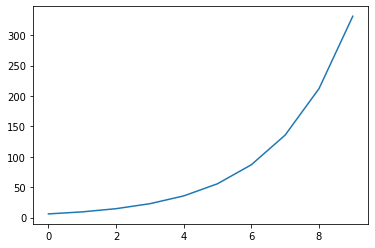

In [243]:
x = np.arange(10)
y = 5.97*np.power(np.repeat(1.5624, 10), x)
plt.plot(x, y)

32


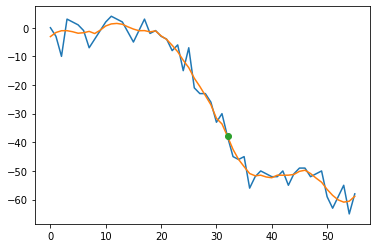

In [18]:
county_t = google.where("county_st", "Orange County, California").column("transit stations")
county_ts = savgol_filter(county_t, 11, 3)
plt.plot(np.arange(len(county_t)), county_t)
plt.plot(np.arange(len(county_t)), county_ts)
plt.plot(np.argmin(np.gradient(county_ts, 1)), county_ts[np.argmin(np.gradient(county_ts, 1))], marker = 'o')

print(np.argmin(np.gradient(county_ts, 1)))

In [19]:
def get_reactionTime(county):
    county_t = google.where("county_st", county).column("transit stations")
    if (len(county_t) < 21):
        return -1
    county_ts = savgol_filter(county_t, 21, 3)
    return np.argmin(np.gradient(county_ts, 1))

In [20]:
reaction_time = []
for county in g_counties:
    reaction_time.append(get_reactionTime(county))
    
google_rt = Table().with_columns("county", g_counties, "reaction_time", reaction_time)

google_rt

In [26]:
county_gr_rt = nytimes_gr.join("county", google_rt).where("reaction_time", are.not_equal_to(0))


In [173]:
county_gr_rt.to_csv("county_gr_rt_transit.csv")

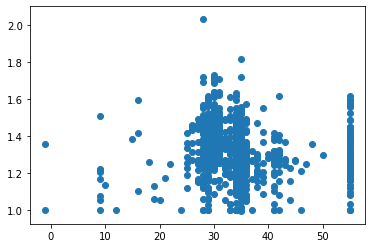

In [36]:
#county: growth rate vs rxn time using transit mobility
plt.scatter(county_gr_rt.column("reaction_time"), county_gr_rt.column("growth_rate"))


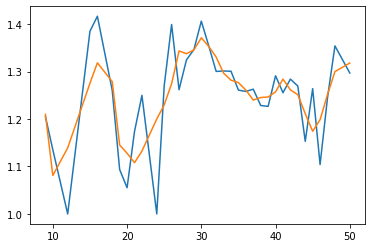

In [68]:
#county: growth rate median (grouped by rxn time) vs rxn time using transit mobility
county_gr_rt_med = county_gr_rt.group("reaction_time", np.median).where("reaction_time", are.between(1, 55))
plt.plot(county_gr_rt_med.column("reaction_time"), county_gr_rt_med.column("growth_rate median"))
plt.plot(county_gr_rt_med.column("reaction_time"), savgol_filter(county_gr_rt_med.column("growth_rate median"), 7, 3))


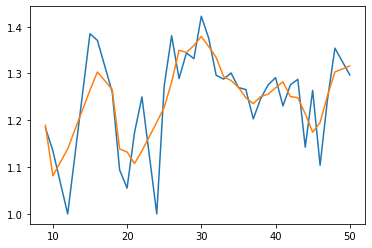

In [69]:
#county: growth rate mean (grouped by rxn time) vs rxn time using transit mobility
county_gr_rt_mean = county_gr_rt.group("reaction_time", np.mean).where("reaction_time", are.between(1, 55))
plt.plot(county_gr_rt_mean.column("reaction_time"), county_gr_rt_mean.column("growth_rate mean"))
plt.plot(county_gr_rt_mean.column("reaction_time"), savgol_filter(county_gr_rt_mean.column("growth_rate mean"), 7, 3))


In [74]:
all_m = google.column(3) + google.column(4) + google.column(5) + google.column(6) + google.column(7) + google.column(8)
google = google.with_column("all", all_m)
google

state,county,date,retail,grocery and pharmacy,parks,transit stations,workplaces,residential,cases,deaths,county_st,all
Alabama,Baldwin County,2020-02-15,17,12,55,8,6,-2,0,0,"Baldwin County, Alabama",96
Alabama,Baldwin County,2020-02-16,8,8,-12,7,-3,2,0,0,"Baldwin County, Alabama",10
Alabama,Baldwin County,2020-02-17,9,9,31,7,-3,1,0,0,"Baldwin County, Alabama",54
Alabama,Baldwin County,2020-02-18,7,8,21,7.5,2,0,0,0,"Baldwin County, Alabama",45.5
Alabama,Baldwin County,2020-02-19,12,9,41,8,3,-1,0,0,"Baldwin County, Alabama",72
Alabama,Baldwin County,2020-02-20,5,5,-10,4,0,3,0,0,"Baldwin County, Alabama",7
Alabama,Baldwin County,2020-02-21,15,13,59,18,1,-1,0,0,"Baldwin County, Alabama",105
Alabama,Baldwin County,2020-02-22,15,17,56,4,4,-2,0,0,"Baldwin County, Alabama",94
Alabama,Baldwin County,2020-02-23,17,20,92,19,4,-2,0,0,"Baldwin County, Alabama",150
Alabama,Baldwin County,2020-02-24,10,9,12,1,-15,3,0,0,"Baldwin County, Alabama",20


In [75]:
def get_reactionTime_all(county):
    county_t = google.where("county_st", county).column("all")
    if (len(county_t) < 21):
        return -1
    county_ts = savgol_filter(county_t, 21, 3)
    return np.argmin(np.gradient(county_ts, 1))

In [76]:
reaction_time = []
for county in g_counties:
    reaction_time.append(get_reactionTime_all(county))
    
google_rt_all = Table().with_columns("county", g_counties, "reaction_time", reaction_time)

google_rt_all

In [77]:
county_gr_rt_all = nytimes_gr.join("county", google_rt_all).where("reaction_time", are.not_equal_to(0))


In [171]:
county_gr_rt_all


county,growth_rate,reaction_time
"Ada County, Idaho",1.50419,36
"Adams County, Colorado",1.44545,26
"Adams County, Illinois",1.32605,34
"Aiken County, South Carolina",1.36479,30
"Alachua County, Florida",1.32058,34
"Alameda County, California",1.36258,30
"Albany County, New York",1.31565,55
"Albany County, Wyoming",1.13505,34
"Albemarle County, Virginia",1.29138,30
"Allegan County, Michigan",1.3227,34


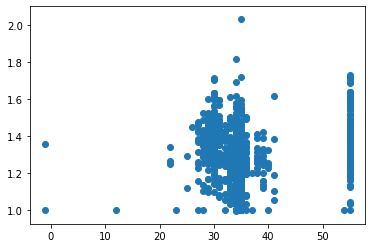

In [78]:
#county: growth rate vs rxn time using all mobility
plt.scatter(county_gr_rt_all.column("reaction_time"), county_gr_rt_all.column("growth_rate"))


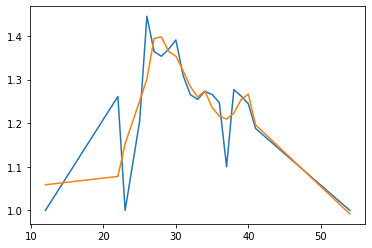

In [79]:
#county: growth rate median (grouped by rxn time) vs rxn time using all mobility
county_gr_rt_all_med = county_gr_rt_all.group("reaction_time", np.median).where("reaction_time", are.between(1, 55))
plt.plot(county_gr_rt_all_med.column("reaction_time"), county_gr_rt_all_med.column("growth_rate median"))
plt.plot(county_gr_rt_all_med.column("reaction_time"), savgol_filter(county_gr_rt_all_med.column("growth_rate median"), 7, 3))


In [222]:
county_gr_rt_all_med.group("reaction_time", np.median).to_csv("county_rt_vs_ave_gr.csv")

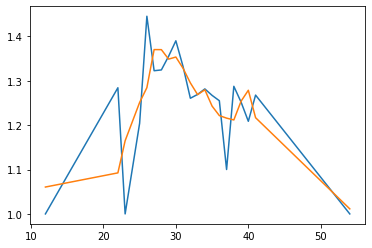

In [82]:
#county: growth rate mean (grouped by rxn time) vs rxn time using all mobility
county_gr_rt_all_mean = county_gr_rt_all.group("reaction_time", np.mean).where("reaction_time", are.between(1, 55))
plt.plot(county_gr_rt_all_mean.column("reaction_time"), county_gr_rt_all_mean.column("growth_rate mean"))
plt.plot(county_gr_rt_all_mean.column("reaction_time"), savgol_filter(county_gr_rt_all_mean.column("growth_rate mean"), 7, 3))


In [133]:
global_df = pd.read_csv("master_df_countries.csv")
global_df.fillna(0, inplace = True)
global_t = Table.from_df(global_df)

In [134]:
all_mg = global_t.column(3) + global_t.column(5)+ global_t.column(7) + global_t.column(8) + global_t.column(9) + global_t.column(10)
global_t = global_t.with_column("all", all_mg)
global_t = global_t.where("region", "Total")
global_t

Unnamed: 0,country,date,grocery and pharmacy,index,parks,region,residential,retail,transit stations,workplaces,cases,deaths,all
0,Afghanistan,2020-02-15,-10,456,0,Total,5,-9,-2,-28,0,0,-44
1,Afghanistan,2020-02-16,11,457,1,Total,0,3,10,4,0,0,29
2,Afghanistan,2020-02-17,11,458,2,Total,-1,6,9,5,0,0,32
3,Afghanistan,2020-02-18,5,459,3,Total,-1,3,9,6,0,0,25
4,Afghanistan,2020-02-19,3,460,1,Total,1,-1,0,5,0,0,9
5,Afghanistan,2020-02-20,3,461,-1,Total,1,-2,4,6,0,0,11
6,Afghanistan,2020-02-21,9,462,4,Total,0,0,7,6,0,0,26
7,Afghanistan,2020-02-22,5,463,6,Total,0,2,7,6,0,0,26
8,Afghanistan,2020-02-23,6,464,2,Total,1,2,7,6,0,0,24
9,Afghanistan,2020-02-24,13,465,4,Total,0,3,9,7,1,0,36


In [138]:
def get_growthRate_global(country):
    temp = global_t.where("country", country)
    X = np.arange(len(temp.get(0)))
    X = sm.add_constant(X)
    Y = temp.column("cases")
    Y = np.log(np.add(Y, 1))

    mod = sm.OLS(Y, X)
    res = mod.fit()
    return 10**res.params[1]

In [ ]:
countries = np.unique(global_t.column("country"))

In [141]:
growth_rate = []
for country in countries:
    growth_rate.append(get_growthRate_global(country))
    
jhu_gr_countries = Table().with_columns("country", countries, "growth_rate", growth_rate)

In [142]:
jhu_gr_countries

country,growth_rate
Afghanistan,1.35183
Angola,1.14626
Antigua and Barbuda,1.15379
Argentina,1.49217
Austria,1.62464
Bahrain,1.33489
Bangladesh,1.3083
Barbados,1.24574
Belarus,1.3922
Belgium,1.63614


In [135]:
def get_reactionTime_global(country):
    country_t = global_t.where("country", country).column("all")
    if (len(country_t) < 21):
        return -1
    country_ts = savgol_filter(country_t, 21, 3)
    num_z = np.count_nonzero(global_t.where("country", country).column("cases")==0)
    return (np.argmin(np.gradient(country_ts, 1)) - num_z)

In [136]:
reaction_time = []
for country in countries:
    reaction_time.append(get_reactionTime_global(country))
    
google_rt_countries = Table().with_columns("country", countries, "reaction_time", reaction_time)

In [137]:
google_rt_countries

country,reaction_time
Afghanistan,28
Angola,5
Antigua and Barbuda,20
Argentina,14
Austria,21
Bahrain,25
Bangladesh,14
Barbados,15
Belarus,34
Belgium,30


In [144]:
country_gr_rt_all = jhu_gr_countries.join("country", google_rt_countries).where("reaction_time", are.not_equal_to(0))


In [145]:
country_gr_rt_all


country,growth_rate,reaction_time
Afghanistan,1.35183,28
Angola,1.14626,5
Antigua and Barbuda,1.15379,20
Argentina,1.49217,14
Austria,1.62464,21
Bahrain,1.33489,25
Bangladesh,1.3083,14
Barbados,1.24574,15
Belarus,1.3922,34
Belgium,1.63614,30


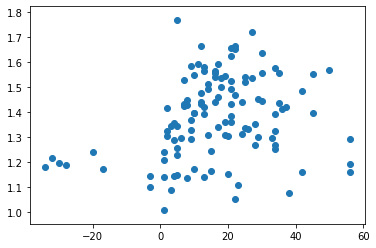

In [180]:
#country: growth rate vs rxn time using all mobility
plt.scatter(country_gr_rt_all.column("reaction_time"), country_gr_rt_all.column("growth_rate"))


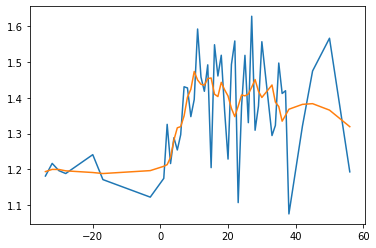

In [162]:
#country: growth rate median (grouped by rxn time) vs rxn time using all mobility
country_gr_rt_all_med = country_gr_rt_all.group("reaction_time", np.median).where("reaction_time", are.between(-45, 60))
plt.plot(country_gr_rt_all_med.column("reaction_time"), country_gr_rt_all_med.column("growth_rate median"))
plt.plot(country_gr_rt_all_med.column("reaction_time"), savgol_filter(country_gr_rt_all_med.column("growth_rate median"), 11, 3))


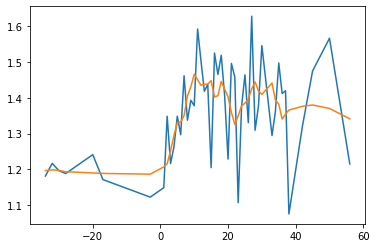

In [163]:
#county: growth rate mean (grouped by rxn time) vs rxn time using all mobility
country_gr_rt_all_mean = country_gr_rt_all.group("reaction_time", np.mean).where("reaction_time", are.between(-45, 60))
plt.plot(country_gr_rt_all_mean.column("reaction_time"), country_gr_rt_all_mean.column("growth_rate mean"))
plt.plot(country_gr_rt_all_mean.column("reaction_time"), savgol_filter(country_gr_rt_all_mean.column("growth_rate mean"), 11, 3))


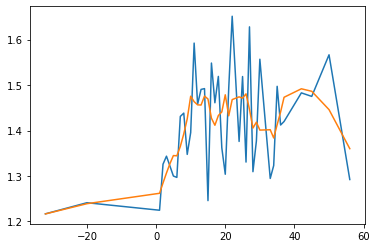

In [206]:
temp = country_gr_rt_all.where("growth_rate", are.above(1.2))

#country: growth rate median (grouped by rxn time) vs rxn time using all mobility
temp1 = temp.group("reaction_time", np.median).where("reaction_time", are.between(-45, 60))
plt.plot(temp1.column("reaction_time"), temp1.column("growth_rate median"))
plt.plot(temp1.column("reaction_time"), savgol_filter(temp1.column("growth_rate median"), 11, 3))


In [225]:
from scipy.optimize import curve_fit

def func(x, a, b, c):
    return (c/(a*np.exp(-b*x) + 1) + 1.2)
# Using the python scipy function curve_fit with function and input variables
popt, pcov = curve_fit(func, temp1.column("reaction_time"), savgol_filter(temp1.column("growth_rate median"), 11, 3))

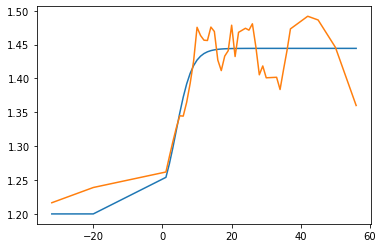

In [226]:
plt.plot(temp1.column("reaction_time"),func(temp1.column("reaction_time"),popt[0],popt[1],popt[2]))
plt.plot(temp1.column("reaction_time"), savgol_filter(temp1.column("growth_rate median"), 11, 3))


In [274]:
x = np.arange(-30, 50, 0.1)
y = 0.24436/(1+5.39903*np.exp(-0.426382*x)) + 1.2
Table().with_columns("x", x, "y", y).to_csv("coordinates_log_reg.csv")

In [275]:
global_df = pd.read_csv("master_df_countries.csv")
global_df.fillna(0, inplace = True)
global_t = Table.from_df(global_df)

In [276]:
all_mg = global_t.column(3) + global_t.column(5)+ global_t.column(7) + global_t.column(8) + global_t.column(9) + global_t.column(10)
global_t = global_t.with_column("all", all_mg)
global_t = global_t.where("region", "Total")
global_t

Unnamed: 0,country,date,grocery and pharmacy,index,parks,region,residential,retail,transit stations,workplaces,cases,deaths,all
0,Afghanistan,2020-02-15,-10,456,0,Total,5,-9,-2,-28,0,0,-44
1,Afghanistan,2020-02-16,11,457,1,Total,0,3,10,4,0,0,29
2,Afghanistan,2020-02-17,11,458,2,Total,-1,6,9,5,0,0,32
3,Afghanistan,2020-02-18,5,459,3,Total,-1,3,9,6,0,0,25
4,Afghanistan,2020-02-19,3,460,1,Total,1,-1,0,5,0,0,9
5,Afghanistan,2020-02-20,3,461,-1,Total,1,-2,4,6,0,0,11
6,Afghanistan,2020-02-21,9,462,4,Total,0,0,7,6,0,0,26
7,Afghanistan,2020-02-22,5,463,6,Total,0,2,7,6,0,0,26
8,Afghanistan,2020-02-23,6,464,2,Total,1,2,7,6,0,0,24
9,Afghanistan,2020-02-24,13,465,4,Total,0,3,9,7,1,0,36


In [278]:
def get_growthRate_global(country):
    temp = global_t.where("country", country)
    X = np.arange(len(temp.get(0)))
    X = sm.add_constant(X)
    Y = temp.column("cases")
    Y = np.log(np.add(Y, 1))

    mod = sm.OLS(Y, X)
    res = mod.fit()
    return np.exp(res.params[1])

In [279]:
countries = np.unique(global_t.column("country"))

In [280]:
growth_rate = []
for country in countries:
    growth_rate.append(get_growthRate_global(country))
    
jhu_gr_countries = Table().with_columns("country", countries, "growth_rate", growth_rate)

In [281]:
jhu_gr_countries

country,growth_rate
Afghanistan,1.13988
Angola,1.06108
Antigua and Barbuda,1.0641
Argentina,1.18984
Austria,1.23461
Bahrain,1.13366
Bangladesh,1.12379
Barbados,1.10013
Belarus,1.15454
Belgium,1.2384


In [282]:
country_gr_rt_all = jhu_gr_countries.join("country", google_rt_countries).where("reaction_time", are.not_equal_to(0))


In [283]:
country_gr_rt_all


country,growth_rate,reaction_time
Afghanistan,1.13988,28
Angola,1.06108,5
Antigua and Barbuda,1.0641,20
Argentina,1.18984,14
Austria,1.23461,21
Bahrain,1.13366,25
Bangladesh,1.12379,14
Barbados,1.10013,15
Belarus,1.15454,34
Belgium,1.2384,30


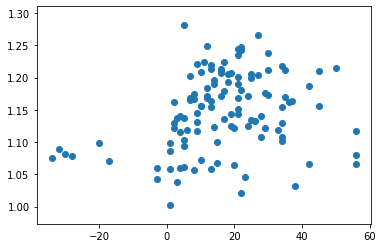

In [284]:
#country: growth rate vs rxn time using all mobility
plt.scatter(country_gr_rt_all.column("reaction_time"), country_gr_rt_all.column("growth_rate"))


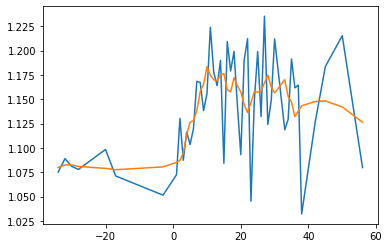

In [285]:
#country: growth rate median (grouped by rxn time) vs rxn time using all mobility
country_gr_rt_all_med = country_gr_rt_all.group("reaction_time", np.median).where("reaction_time", are.between(-45, 60))
plt.plot(country_gr_rt_all_med.column("reaction_time"), country_gr_rt_all_med.column("growth_rate median"))
plt.plot(country_gr_rt_all_med.column("reaction_time"), savgol_filter(country_gr_rt_all_med.column("growth_rate median"), 11, 3))


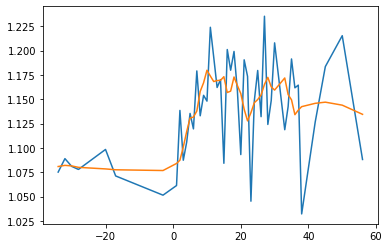

In [286]:
#county: growth rate mean (grouped by rxn time) vs rxn time using all mobility
country_gr_rt_all_mean = country_gr_rt_all.group("reaction_time", np.mean).where("reaction_time", are.between(-45, 60))
plt.plot(country_gr_rt_all_mean.column("reaction_time"), country_gr_rt_all_mean.column("growth_rate mean"))
plt.plot(country_gr_rt_all_mean.column("reaction_time"), savgol_filter(country_gr_rt_all_mean.column("growth_rate mean"), 11, 3))


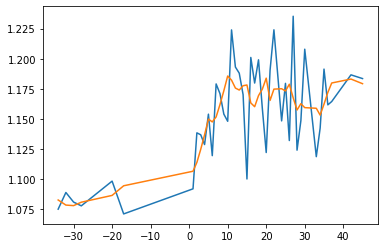

In [300]:
temp = country_gr_rt_all.where("growth_rate", are.above(1.07))
temp = temp.where("reaction_time", are.below(50))

#country: growth rate median (grouped by rxn time) vs rxn time using all mobility
temp1 = temp.group("reaction_time", np.mean).where("reaction_time", are.between(-45, 50))
plt.plot(temp1.column("reaction_time"), temp1.column("growth_rate mean"))
plt.plot(temp1.column("reaction_time"), savgol_filter(temp1.column("growth_rate mean"), 11, 3))


In [309]:
rt = temp1.column("reaction_time")
gr_m = savgol_filter(temp1.column("growth_rate mean"), 11, 3)
t1 = Table().with_columns("reaction_time", rt, "growth_rate mean", gr_m)

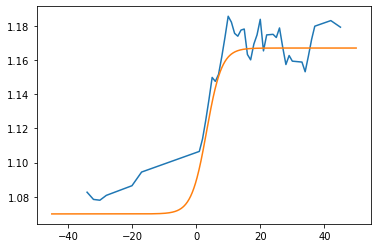

In [321]:
plt.plot(t1.column(0), t1.column(1))
plt.plot(t2.column(0), t2.column(1))


In [310]:
x = np.arange(-45, 50, 0.1)
y = 0.09704/(1+4.04421*np.exp(-0.424991*x)) + 1.07
t2 = Table().with_columns("reaction_time", x, "growth_rate log curve", y)
